In [13]:
# 初始化配置
import qlib
from qlib.constant import REG_CN
data_uri = '~/.qlib/qlib_data/cn_data/'
qlib.init(provider_uri=data_uri, region=REG_CN)

# 使用"配置"进行实例化
from qlib.utils import init_instance_by_config
qdl_config = {
    "class": "QlibDataLoader",
    "module_path": "qlib.data.dataset.loader",
    "kwargs": {
        "config": {
            "feature": (['EMA($close, 10)', 'EMA($close, 30)'], ['EMA10', 'EMA30'] ),
            "label": (['Ref($close, -1)/$close - 1',],['RET_1',]),
        },
        "freq": 'day',
    },
}
qdl = init_instance_by_config(qdl_config)
market = 'csi300' # 沪深300股票池代码，在instruments文件夹下有对应的sh000300.txt
qdl.load(instruments=market, start_time='20200101', end_time='20200110')

[909548:MainThread](2024-11-27 21:18:56,747) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[909548:MainThread](2024-11-27 21:18:56,750) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[909548:MainThread](2024-11-27 21:18:56,751) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/hhh/.qlib/qlib_data/cn_data')}


feature                label
                           EMA10      EMA30     RET_1
datetime   instrument                                
2020-01-02 SH600000     9.171472   9.060854  1.010425
           SH600004     6.221383   6.198955  0.992009
           SH600009    25.708969  25.645361  0.999224
           SH600010     4.653900   4.625497  1.007519
           SH600011     2.117210   2.154742  1.000000
...                          ...        ...       ...
2020-01-10 SZ300347    17.478148  17.084019  0.994388
           SZ300408     2.253388   2.172849  1.002635
           SZ300413     5.067583   4.742254  1.017136
           SZ300433     2.601543   2.478502  1.060436
           SZ300498     1.029452   1.002125  1.013001

[2100 rows x 3 columns]

In [8]:
# 实现一个自定义的特征集，MACD、RSI

from qlib.data.dataset.handler import DataHandlerLP

class MyFeatureSet(DataHandlerLP):
    def __init__(self,
                 instruments="csi300", 
                 start_time=None,
                 end_time=None,
                 freq="day",
                 infer_processors=[],
                 learn_processors=[],
                 fit_start_time=None,
                 fit_end_time=None,
                 process_type=DataHandlerLP.PTYPE_A,
                 filter_pipe=None,
                 **kwargs,
                ):
        data_loader = {
            "class": "QlibDataLoader",
            "kwargs": {
                "config": {
                    "feature": self.get_feature_config(),
                    "label": kwargs.get("label", self.get_label_config()), # label可以自定义，也可以使用初始化时候的设置
                },
                "filter_pipe": filter_pipe,
                "freq": freq,
                },
            }
        super().__init__(
            instruments=instruments,
            start_time=start_time,
            end_time=end_time,
            data_loader=data_loader,
            infer_processors=infer_processors,
            learn_processors=learn_processors,
            process_type=process_type,
        )
        
    def get_feature_config(self):
        
        MACD = '(EMA($close, 12) - EMA($close, 26))/$close - EMA((EMA($close, 12) - EMA($close, 26))/$close, 9)/$close'
        RSI = '100 - 100/(1+(Sum(Greater($close-Ref($close, 1),0), 14)/Count(($close-Ref($close, 1))>0, 14))/ (Sum(Abs(Greater(Ref($close, 1)-$close,0)), 14)/Count(($close-Ref($close, 1))<0, 14)))'
        
        return [MACD, RSI ], ['MACD', 'RSI']

    def get_label_config(self):
        return (["Ref($close, -1)/$close - 1"], ["LABEL"])

# 初始化的过程中已经完成的数据的load
my_feature = MyFeatureSet(instruments='csi300', start_time='2017-01-01', end_time='2018-12-31')

# my_feature.get_feature_config()
my_feature.fetch() # my_feature.fetch(col_set='feature') / my_feature.fetch(col_set='label')

[2082340:MainThread](2024-12-02 21:27:12,908) INFO - qlib.timer - [log.py:127] - Time cost: 1.733s | Loading data Done
[2082340:MainThread](2024-12-02 21:27:12,909) INFO - qlib.timer - [log.py:127] - Time cost: 0.000s | fit & process data Done
[2082340:MainThread](2024-12-02 21:27:12,910) INFO - qlib.timer - [log.py:127] - Time cost: 1.735s | Init data Done


MACD        RSI     LABEL
datetime   instrument                               
2017-01-03 SH600000   -0.011053  21.939018  0.001834
           SH600008   -0.004141  57.575714  0.007246
           SH600009   -0.001988  59.183758  0.005253
           SH600010   -0.010420  37.498512  0.000000
           SH600015   -0.011868  37.209003  0.005386
...                         ...        ...       ...
2018-12-28 SZ300144   -0.006135  67.208672 -0.085714
           SZ300251    0.007292  42.944771  0.022368
           SZ300296   -0.015401  43.870964 -0.016905
           SZ300408   -0.004692  49.664413 -0.043735
           SZ300433   -0.013095  14.838701 -0.018433

[146100 rows x 3 columns]

In [1]:

import qlib
from qlib.constant import REG_CN
data_uri = '~/.qlib/qlib_data/cn_data/'
qlib.init(provider_uri=data_uri, region=REG_CN)
from qlib.data.dataset.handler import DataHandlerLP

# 使用"配置"进行实例化
from qlib.utils import init_instance_by_config
from qlib.contrib.data.handler import Alpha158
from qlib.data.dataset import TSDatasetH
from qlib.contrib.model.pytorch_alstm_ts import ALSTM

# 配置数据
train_period = ("2018-01-01", "2018-12-31")
valid_period = ("2019-01-01", "2019-12-31")
test_period = ("2020-01-01", "2020-08-01")

dh = Alpha158(instruments='csi300', 
              start_time=train_period[0], 
              end_time=test_period[1],
             fit_start_time = "2018-01-01",
             fit_end_time = "2019-12-31",
              infer_processors= [
                        {"class": "RobustZScoreNorm", "kwargs": {"fields_group": "feature", "clip_outlier": "true"}},
                        {"class": "Fillna", "kwargs": {"fields_group": "feature"}},
                    ],
            learn_processors= [
                        "DropnaLabel",
                        {"class": "CSRankNorm", "kwargs": {"fields_group": "label"}},  # CSRankNorm
                    ],
             )
ds = TSDatasetH(handler=dh,
                step_len=20, # 时间步数
                segments={"train": train_period, 
                          "valid": valid_period, 
                          "test": test_period})


[2209154:MainThread](2024-12-03 21:57:17,213) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[2209154:MainThread](2024-12-03 21:57:17,407) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[2209154:MainThread](2024-12-03 21:57:17,408) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/hhh/.qlib/qlib_data/cn_data')}


ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).
-------------DropnaLabel: label


/home/hhh/proj/qlib-main/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2209154:MainThread](2024-12-03 21:57:31,224) INFO - qlib.timer - [log.py:127] - Time cost: 12.462s | Loading data Done
/home/hhh/proj/qlib-main/venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
[2209154:MainThread](2024-12-03 21:57:33,947) INFO - qlib.timer - [log.py:127] - Time cost: 2.665s | RobustZScoreNorm Done
[2209154:MainThread](2024-12-03 21:57:34,034) INFO - qlib.timer - [log.py:127] - Time cost: 0.087s | Fillna Done
[2209154:MainThread](2024-12-03 21:57:34,090) INFO - qlib.timer - [log.py:127] - Time cost: 0.036s | DropnaLabel Done
/home/hhh/proj/qlib-main/qlib/data/dataset/processor.py:37

In [2]:
ds.prepare("train")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
#%%
from qlib.data.dataset.handler import DataHandlerLP
dl_train = ds.prepare("train", col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)
dl_valid = ds.prepare("valid", col_set=["feature", "label"], data_key=DataHandlerLP.DK_L)


In [4]:
dl_train.config(fillna_type="ffill+bfill")  # process nan brought by dataloader
dl_valid.config(fillna_type="ffill+bfill")

In [5]:
import numpy as np
import torch.nn as nn
import torch
import math
seed = 32
np.random.seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

train_loader = DataLoader(
dl_train, batch_size=5192, shuffle=True, num_workers=0, drop_last=True
)
valid_loader = DataLoader(
dl_valid, batch_size=5192, shuffle=True, num_workers=0, drop_last=True
)

Epoch 0
train 1.526563, valid 1.225405
Epoch 1
train 1.389690, valid 1.192478
Epoch 2
train 1.328567, valid 1.516166
Epoch 3
train 2.614228, valid 1.628637
Epoch 4
train 1.225518, valid 1.193989


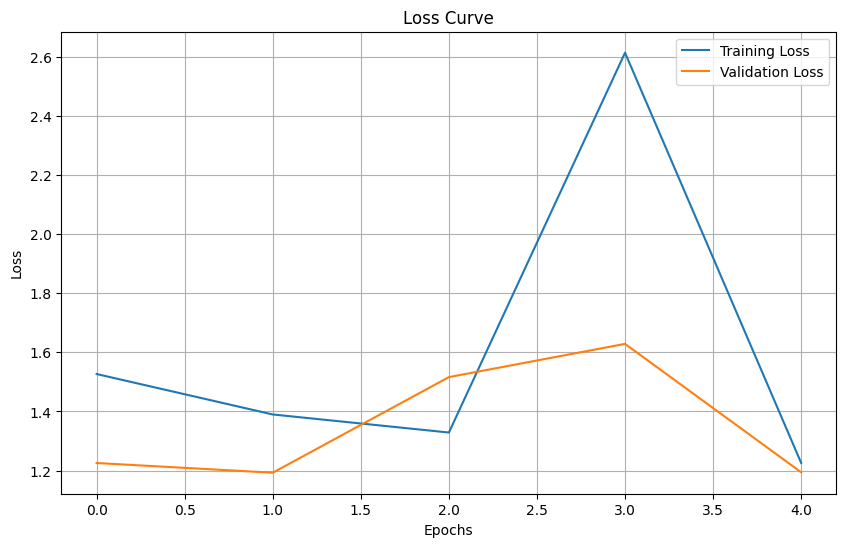

In [6]:
from transformerModule import train_transformer, test_transformer
import matplotlib.pyplot as plt
n_epochs = 5
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    print("Epoch %d" % epoch)
    train_transformer(train_loader, epoch)
    train_loss, train_score =test_transformer(train_loader)
    val_loss, val_score = test_transformer(valid_loader)
    print("train %.6f, valid %.6f" % (train_score, val_score))
    train_losses.append(train_loss)
    val_losses.append(val_loss)


# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
 
# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
for batch_idx, inputs in enumerate(train_loader):  
    if batch_idx == 1:  
        one_batch_data = inputs
        break   


In [19]:
one_batch_data

tensor([[[ 0.1387,  0.1772,  0.1145,  ...,  0.2158,  0.4777,  2.0210],
         [ 0.8577,  0.0810,  0.7436,  ...,  0.2945, -0.1825,  1.9877],
         [ 1.3295,  0.0739,  1.1570,  ...,  0.3415,  0.7349,  2.0322],
         ...,
         [ 1.6707,  0.6314,  1.1274,  ...,  0.6846, -0.4380,  1.9925],
         [ 0.2362, -0.3038,  0.2558,  ..., -0.1987, -0.4414,  1.9705],
         [-0.4864,  0.5911, -0.3337,  ..., -0.5573, -0.4111,  1.9950]],

        [[ 0.8577,  0.0810,  0.7436,  ...,  0.2945, -0.1825,  1.9877],
         [ 1.3295,  0.0739,  1.1570,  ...,  0.3415,  0.7349,  2.0322],
         [-0.7952,  0.1659, -0.6604,  ...,  0.6540,  0.9253,  2.0003],
         ...,
         [ 0.2362, -0.3038,  0.2558,  ..., -0.1987, -0.4414,  1.9705],
         [-0.4864,  0.5911, -0.3337,  ..., -0.5573, -0.4111,  1.9950],
         [-1.7438,  1.5083, -0.8695,  ...,  0.1983, -0.0648,  1.9972]],

        [[ 1.3295,  0.0739,  1.1570,  ...,  0.3415,  0.7349,  2.0322],
         [-0.7952,  0.1659, -0.6604,  ...,  0

In [9]:
# 一个batch的数据
one_batch_data.shape

torch.Size([8192, 20, 159])

In [7]:

# feature: (8192,20,158)
feature = one_batch_data[:, :, 0:-1]
# 8192
label = one_batch_data[:, -1, -1]
print(feature.shape)
print(label)


torch.Size([8192, 20, 158])
tensor([0.9950, 0.9972, 0.9717,  ..., 0.9979, 0.9978, 0.9978])


In [21]:
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import math
seed = 32
np.random.seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
from transformerModule import PositionalEncoding, MultiHeadAttention,TransformerModule
# linear = nn.Linear()

# input = torch.randn(20,5,158)
# mul_att1 = MultiHeadAttention(2,512,0)
# mul_att_out1 = mul_att1.forward(input)
# print(mul_att_out1)
# mul_att2 = PositionalEncoding(512, 100)
# mul_att_out2 = mul_att2.forward(input.float())
# 模型输出测试
model = TransformerModule(158, 512, 0.1, 6)
pred = model.forward(feature.float()).squeeze(-1)
train_optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
mask = ~torch.isnan(label)
loss = torch.mean((pred[mask]-label[mask])**2)
train_optimizer.zero_grad()
loss.backward()
train_optimizer.step()
print(pred.shape)
print(pred)


Total number of parameters: 1296543


NameError: name 'feature' is not defined

In [12]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

In [19]:
test = torch.rand(3,4,5)

In [20]:
test

tensor([[[0.7605, 0.8524, 0.6648, 0.9480, 0.4735],
         [0.8731, 0.3785, 0.3258, 0.2027, 0.7167],
         [0.8117, 0.1121, 0.6466, 0.9719, 0.9213],
         [0.3831, 0.3930, 0.5797, 0.6329, 0.2640]],

        [[0.9705, 0.4962, 0.7696, 0.2525, 0.0741],
         [0.3559, 0.4318, 0.9146, 0.9795, 0.4408],
         [0.9902, 0.5128, 0.5951, 0.8934, 0.2516],
         [0.4185, 0.4892, 0.6723, 0.3938, 0.6720]],

        [[0.8764, 0.2443, 0.3268, 0.9680, 0.2575],
         [0.3969, 0.0577, 0.7201, 0.4786, 0.4490],
         [0.8341, 0.8497, 0.9446, 0.2704, 0.6773],
         [0.5130, 0.7120, 0.9063, 0.8501, 0.9215]]])

In [21]:
test[:,-1,:]

tensor([[0.3831, 0.3930, 0.5797, 0.6329, 0.2640],
        [0.4185, 0.4892, 0.6723, 0.3938, 0.6720],
        [0.5130, 0.7120, 0.9063, 0.8501, 0.9215]])

In [23]:
test[:,-1,:].shape

torch.Size([3, 5])